In [1]:
# This is the method that uses the MATLAB Engine API for Python
import matlab.engine
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torchvision import  models, datasets, transforms
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import timm
import pickle
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import numpy as np
import scipy.io as scio
from scipy.io import savemat
import h5py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import gc

In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else 'cpu'

In [3]:
main_channels = scio.loadmat('main_channels_for_autoencoder.mat')
main_channels_mat = main_channels['main_channels']

main_channels_mat = torch.load('main_channels_tensor_for_autoencoder.pt', weights_only=True)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, main_channels_mat):
        # convert into PyTorch tensors and remember them
        self.main_channels_mat = main_channels_mat

    def __len__(self):
        # this should return the size of the dataset
        return len(self.main_channels_mat)
    
    def __getitem__(self, idx):
        # this should return one sample from the dataset
        main_channels_mat = self.main_channels_mat[idx,:,:]
        return main_channels_mat

In [5]:
dataset = CustomDataset(main_channels_mat)

In [6]:
# First, split the dataset into train and remaining (val + test)
train_set, remaining_set = train_test_split(dataset, test_size=40000, random_state=42)

# Now, split the remaining set into validation and test sets
val_set, test_set = train_test_split(remaining_set, test_size=20000, random_state=42)

In [7]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size= batch_size)

In [8]:
batch_main_chan_mat = next(iter(train_loader))

print(f'Shape of batch feature is {batch_main_chan_mat.shape}')
print(f'Data type of batch feature is {batch_main_chan_mat.dtype}')

Shape of batch feature is torch.Size([64, 10, 70])
Data type of batch feature is torch.complex64


In [9]:
class CSIEncoder(nn.Module):
    def __init__(self):
        super(CSIEncoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bnconv1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bnconv2 = nn.BatchNorm2d(32)

        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(1728, 280)
        self.bnlin1 = nn.BatchNorm1d(280)
        
        self.linear2 = nn.Linear(280, 140)



    def forward(self, x):
        #x = x.unsqueeze(1)
        x = F.relu(self.bnconv1(self.conv1(x)))
        x = F.relu(self.bnconv2(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.bnlin1(self.linear1(x)))
        x = self.linear2(x)

        return x

In [10]:
test_output_enc = CSIEncoder()(torch.rand([64,2,10,70]))
test_output_enc.shape

torch.Size([64, 140])

In [11]:
class CSIDecoder(nn.Module):
    def __init__(self):
        super(CSIDecoder, self).__init__()
        
        self.linear1 = nn.Linear(140, 280)
        self.bnlin1 = nn.BatchNorm1d(280)
        
        self.linear2 = nn.Linear(280, 1728)
        self.bnlin2 = nn.BatchNorm1d(1728)

        self.unflatten = nn.Unflatten(1,[32, 3, 18])
        
        self.convT1 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bnconv1 = nn.BatchNorm2d(32)

        self.convT2 = nn.ConvTranspose2d(in_channels=32, out_channels=2, kernel_size=3, stride=2, padding=2, output_padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        #x = x.unsqueeze(1)
        x = F.relu(self.bnlin1(self.linear1(x)))
        x = F.relu(self.bnlin2(self.linear2(x)))
        x = self.unflatten(x)
        x = F.relu(self.bnconv1(self.convT1(x)))
        x = self.convT2(x)
       
        return x

In [12]:
test_output_dec = CSIDecoder()(torch.rand([64,140]))
test_output_dec.shape

torch.Size([64, 2, 10, 70])

In [13]:
class AutoEncode(nn.Module):
    def __init__(self):
        super(AutoEncode, self).__init__()
        
        self.encoder = CSIEncoder()
        self.decoder = CSIDecoder()


    def forward(self, x):
        #x = x.unsqueeze(1)
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [14]:
test_output_auto = AutoEncode()(torch.rand([64,2,10,70]))
test_output_auto.shape

torch.Size([64, 2, 10, 70])

In [15]:
model = AutoEncode().to(device)

# Define the loss functions
loss = torch.nn.MSELoss()  # For classification

# Define an optimizer (both for the encoder and the decoder!)
#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)  # Learning rate decay scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=3)

# Variables for early stopping and best parameters
best_loss = float('inf')
patience_limit = 10


best_encoder_model = None
best_decoder_model = None
encoder_path = "best_encoder_sgd.pth"
decoder_path = "best_decoder_sgd.pth"

train_losses = []
val_losses = []


# Train the model
EPOCHS = 100
for epoch in range(EPOCHS):
    running_train_loss = 0.0
    
    model.train()
    progress_bar_train = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100)
    for index, (main_channels_mat) in progress_bar_train:
        # Forward pass
        #algorithm_output_mat_for_nn = (batch_complex_autocorrelation(algorithm_output_mat)).to(device)
        main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1).to(device)
        
        nn_output = model(main_channels_mat_for_nn)
        
        # Calculate loss
        train_loss = loss(nn_output, main_channels_mat_for_nn)

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Update running loss
        running_train_loss += train_loss.item()
        avg_train_loss = running_train_loss / (index + 1)

        # Get current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']

        # Print metrics
        #progress_bar_train.set_description(f'Epoch [{epoch + 1}/{EPOCHS}] MSELos:{avg_train_loss1:.4f} MSEWeig{mse_weight:.2f} CELos:{avg_train_loss2:.4f} CEWeig{ce_weight:.2f} TrLos:{avg_train_loss:.4f} Tr.Acc: {avg_train_acc*100:.2f}%')
        progress_bar_train.set_description(f" Epoch [{epoch + 1}/{EPOCHS}] T Loss:{avg_train_loss:.4f} LR is {current_lr:.6f}")
    
    #train_losses.append(avg_train_loss)
    train_losses.append(avg_train_loss)

    print(f"Training has completed epoch {epoch+1}")
    
    # Validation loop
    running_val_loss = 0.0

    
    model.eval()
    progress_bar_val = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100)
    for index, (main_channels_mat) in progress_bar_val:
        
        #algorithm_output_mat_for_nn = (batch_complex_autocorrelation(algorithm_output_mat)).to(device)
        main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1).to(device)

        
        with torch.no_grad():
            
            nn_output = model(main_channels_mat_for_nn)

            # Calculate losses
            val_loss = loss(nn_output, main_channels_mat_for_nn)

            # Update running loss
            running_val_loss += val_loss.item()
            
            avg_val_loss = running_val_loss / (index + 1)
            
            progress_bar_val.set_description(f" Epoch [{epoch + 1}/{EPOCHS}] V Loss:{avg_val_loss:.4f}")
    
    #val_losses.append(avg_val_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step(running_val_loss)


    # Early stopping
    if avg_val_loss < best_loss:  # Now checking for the best accuracy
        best_loss = avg_val_loss
        best_epoch = epoch + 1
        best_train_loss = avg_train_loss
        patience_ = 0
        best_encoder_weights = copy.deepcopy(model.encoder.state_dict())
        best_decoder_weights = copy.deepcopy(model.decoder.state_dict())
        print(f"Best Validation Loss is now: {best_loss:.4f} at Epoch: {best_epoch}")
    else:
        patience_ += 1
        print(f"This is Epoch: {patience_} without improvement")
        print(f"Current Validation Loss is: {avg_val_loss:.4f} at Epoch: {epoch+1}")
        print(f"Best Validation Loss remains: {best_loss:.4f} at Epoch: {best_epoch}")
        if patience_ > patience_limit:  # Patience limit before stopping
            print("Early stopping triggered! Restoring best model weights.")
            print(f"Best Validation Loss was: {best_loss:.4f} at Epoch: {best_epoch}")
            break

best_encoder_model = model.encoder.cpu()
best_encoder_model.load_state_dict(best_encoder_weights)

best_decoder_model = model.decoder.cpu()
best_decoder_model.load_state_dict(best_decoder_weights)


Epoch [1/100] T Loss:0.5349 LR is 0.010000: 100%|█████████████| 2500/2500 [00:14<00:00, 176.85it/s]

Training has completed epoch 1



Epoch [1/100] V Loss:0.5063: 100%|██████████████████████████████| 313/313 [00:01<00:00, 247.41it/s]

Best Validation Loss is now: 0.5063 at Epoch: 1



Epoch [2/100] T Loss:0.5042 LR is 0.010000: 100%|█████████████| 2500/2500 [00:13<00:00, 191.22it/s]

Training has completed epoch 2



Epoch [2/100] V Loss:0.5026: 100%|██████████████████████████████| 313/313 [00:01<00:00, 285.03it/s]

Best Validation Loss is now: 0.5026 at Epoch: 2



Epoch [3/100] T Loss:0.5021 LR is 0.010000: 100%|█████████████| 2500/2500 [00:13<00:00, 187.45it/s]

Training has completed epoch 3



Epoch [3/100] V Loss:0.5014: 100%|██████████████████████████████| 313/313 [00:01<00:00, 289.25it/s]

Best Validation Loss is now: 0.5014 at Epoch: 3



Epoch [4/100] T Loss:0.5012 LR is 0.010000: 100%|█████████████| 2500/2500 [00:13<00:00, 179.03it/s]

Training has completed epoch 4



Epoch [4/100] V Loss:0.5008: 100%|██████████████████████████████| 313/313 [00:01<00:00, 289.36it/s]

Best Validation Loss is now: 0.5008 at Epoch: 4



Epoch [5/100] T Loss:0.5008 LR is 0.010000: 100%|█████████████| 2500/2500 [00:13<00:00, 180.75it/s]

Training has completed epoch 5



Epoch [5/100] V Loss:0.5004: 100%|██████████████████████████████| 313/313 [00:01<00:00, 297.79it/s]

Best Validation Loss is now: 0.5004 at Epoch: 5



Epoch [6/100] T Loss:0.5005 LR is 0.010000: 100%|█████████████| 2500/2500 [00:13<00:00, 183.07it/s]

Training has completed epoch 6



Epoch [6/100] V Loss:0.5002: 100%|██████████████████████████████| 313/313 [00:01<00:00, 271.97it/s]

Best Validation Loss is now: 0.5002 at Epoch: 6



Epoch [7/100] T Loss:0.5003 LR is 0.010000: 100%|█████████████| 2500/2500 [00:13<00:00, 179.31it/s]

Training has completed epoch 7



Epoch [7/100] V Loss:0.5000: 100%|██████████████████████████████| 313/313 [00:01<00:00, 289.93it/s]

Best Validation Loss is now: 0.5000 at Epoch: 7



Epoch [8/100] T Loss:0.5001 LR is 0.010000: 100%|█████████████| 2500/2500 [00:13<00:00, 180.68it/s]

Training has completed epoch 8



Epoch [8/100] V Loss:0.4999: 100%|██████████████████████████████| 313/313 [00:01<00:00, 285.81it/s]

Best Validation Loss is now: 0.4999 at Epoch: 8



Epoch [9/100] T Loss:0.5000 LR is 0.010000: 100%|█████████████| 2500/2500 [00:13<00:00, 188.61it/s]

Training has completed epoch 9



Epoch [9/100] V Loss:0.4998: 100%|██████████████████████████████| 313/313 [00:01<00:00, 281.43it/s]

Best Validation Loss is now: 0.4998 at Epoch: 9



Epoch [10/100] T Loss:0.4999 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.18it/s]

Training has completed epoch 10



Epoch [10/100] V Loss:0.4997: 100%|█████████████████████████████| 313/313 [00:01<00:00, 283.31it/s]

Best Validation Loss is now: 0.4997 at Epoch: 10



Epoch [11/100] T Loss:0.4998 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 176.04it/s]

Training has completed epoch 11



Epoch [11/100] V Loss:0.4996: 100%|█████████████████████████████| 313/313 [00:01<00:00, 287.07it/s]

Best Validation Loss is now: 0.4996 at Epoch: 11



Epoch [12/100] T Loss:0.4997 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 186.78it/s]

Training has completed epoch 12



Epoch [12/100] V Loss:0.4995: 100%|█████████████████████████████| 313/313 [00:01<00:00, 283.72it/s]

Best Validation Loss is now: 0.4995 at Epoch: 12



Epoch [13/100] T Loss:0.4997 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.78it/s]

Training has completed epoch 13



Epoch [13/100] V Loss:0.4995: 100%|█████████████████████████████| 313/313 [00:01<00:00, 273.98it/s]

Best Validation Loss is now: 0.4995 at Epoch: 13



Epoch [14/100] T Loss:0.4996 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 184.02it/s]

Training has completed epoch 14



Epoch [14/100] V Loss:0.4994: 100%|█████████████████████████████| 313/313 [00:01<00:00, 270.89it/s]

Best Validation Loss is now: 0.4994 at Epoch: 14



Epoch [15/100] T Loss:0.4995 LR is 0.010000: 100%|████████████| 2500/2500 [00:15<00:00, 160.15it/s]

Training has completed epoch 15



Epoch [15/100] V Loss:0.4993: 100%|█████████████████████████████| 313/313 [00:01<00:00, 280.13it/s]

Best Validation Loss is now: 0.4993 at Epoch: 15



Epoch [16/100] T Loss:0.4994 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 171.26it/s]

Training has completed epoch 16



Epoch [16/100] V Loss:0.4992: 100%|█████████████████████████████| 313/313 [00:01<00:00, 249.61it/s]

Best Validation Loss is now: 0.4992 at Epoch: 16



Epoch [17/100] T Loss:0.4993 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 178.44it/s]

Training has completed epoch 17



Epoch [17/100] V Loss:0.4992: 100%|█████████████████████████████| 313/313 [00:01<00:00, 284.23it/s]

Best Validation Loss is now: 0.4992 at Epoch: 17



Epoch [18/100] T Loss:0.4992 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 184.14it/s]

Training has completed epoch 18



Epoch [18/100] V Loss:0.4991: 100%|█████████████████████████████| 313/313 [00:01<00:00, 285.00it/s]

Best Validation Loss is now: 0.4991 at Epoch: 18



Epoch [19/100] T Loss:0.4991 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 182.47it/s]

Training has completed epoch 19



Epoch [19/100] V Loss:0.4989: 100%|█████████████████████████████| 313/313 [00:01<00:00, 284.11it/s]

Best Validation Loss is now: 0.4989 at Epoch: 19



Epoch [20/100] T Loss:0.4990 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 185.33it/s]

Training has completed epoch 20



Epoch [20/100] V Loss:0.4988: 100%|█████████████████████████████| 313/313 [00:01<00:00, 280.96it/s]

Best Validation Loss is now: 0.4988 at Epoch: 20



Epoch [21/100] T Loss:0.4989 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 185.46it/s]

Training has completed epoch 21



Epoch [21/100] V Loss:0.4987: 100%|█████████████████████████████| 313/313 [00:01<00:00, 284.34it/s]

Best Validation Loss is now: 0.4987 at Epoch: 21



Epoch [22/100] T Loss:0.4988 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 188.71it/s]

Training has completed epoch 22



Epoch [22/100] V Loss:0.4985: 100%|█████████████████████████████| 313/313 [00:01<00:00, 283.04it/s]

Best Validation Loss is now: 0.4985 at Epoch: 22



Epoch [23/100] T Loss:0.4986 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 180.97it/s]

Training has completed epoch 23



Epoch [23/100] V Loss:0.4983: 100%|█████████████████████████████| 313/313 [00:01<00:00, 284.15it/s]

Best Validation Loss is now: 0.4983 at Epoch: 23



Epoch [24/100] T Loss:0.4984 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 182.79it/s]

Training has completed epoch 24



Epoch [24/100] V Loss:0.4981: 100%|█████████████████████████████| 313/313 [00:01<00:00, 290.67it/s]

Best Validation Loss is now: 0.4981 at Epoch: 24



Epoch [25/100] T Loss:0.4981 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 191.21it/s]

Training has completed epoch 25



Epoch [25/100] V Loss:0.4979: 100%|█████████████████████████████| 313/313 [00:01<00:00, 284.77it/s]

Best Validation Loss is now: 0.4979 at Epoch: 25



Epoch [26/100] T Loss:0.4979 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 182.89it/s]

Training has completed epoch 26



Epoch [26/100] V Loss:0.4976: 100%|█████████████████████████████| 313/313 [00:01<00:00, 261.52it/s]

Best Validation Loss is now: 0.4976 at Epoch: 26



Epoch [27/100] T Loss:0.4975 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 180.40it/s]

Training has completed epoch 27



Epoch [27/100] V Loss:0.4972: 100%|█████████████████████████████| 313/313 [00:01<00:00, 292.76it/s]

Best Validation Loss is now: 0.4972 at Epoch: 27



Epoch [28/100] T Loss:0.4972 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 187.09it/s]

Training has completed epoch 28



Epoch [28/100] V Loss:0.4968: 100%|█████████████████████████████| 313/313 [00:01<00:00, 283.26it/s]

Best Validation Loss is now: 0.4968 at Epoch: 28



Epoch [29/100] T Loss:0.4968 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 179.04it/s]

Training has completed epoch 29



Epoch [29/100] V Loss:0.4964: 100%|█████████████████████████████| 313/313 [00:01<00:00, 283.00it/s]

Best Validation Loss is now: 0.4964 at Epoch: 29



Epoch [30/100] T Loss:0.4963 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 188.86it/s]

Training has completed epoch 30



Epoch [30/100] V Loss:0.4959: 100%|█████████████████████████████| 313/313 [00:01<00:00, 289.11it/s]

Best Validation Loss is now: 0.4959 at Epoch: 30



Epoch [31/100] T Loss:0.4959 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 187.45it/s]

Training has completed epoch 31



Epoch [31/100] V Loss:0.4955: 100%|█████████████████████████████| 313/313 [00:01<00:00, 251.16it/s]

Best Validation Loss is now: 0.4955 at Epoch: 31



Epoch [32/100] T Loss:0.4954 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 187.53it/s]

Training has completed epoch 32



Epoch [32/100] V Loss:0.4950: 100%|█████████████████████████████| 313/313 [00:01<00:00, 287.83it/s]

Best Validation Loss is now: 0.4950 at Epoch: 32



Epoch [33/100] T Loss:0.4949 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 184.68it/s]

Training has completed epoch 33



Epoch [33/100] V Loss:0.4945: 100%|█████████████████████████████| 313/313 [00:01<00:00, 285.01it/s]

Best Validation Loss is now: 0.4945 at Epoch: 33



Epoch [34/100] T Loss:0.4945 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 189.52it/s]

Training has completed epoch 34



Epoch [34/100] V Loss:0.4941: 100%|█████████████████████████████| 313/313 [00:01<00:00, 287.19it/s]

Best Validation Loss is now: 0.4941 at Epoch: 34



Epoch [35/100] T Loss:0.4941 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 183.56it/s]

Training has completed epoch 35



Epoch [35/100] V Loss:0.4936: 100%|█████████████████████████████| 313/313 [00:01<00:00, 283.66it/s]

Best Validation Loss is now: 0.4936 at Epoch: 35



Epoch [36/100] T Loss:0.4937 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 180.92it/s]

Training has completed epoch 36



Epoch [36/100] V Loss:0.4932: 100%|█████████████████████████████| 313/313 [00:01<00:00, 290.79it/s]

Best Validation Loss is now: 0.4932 at Epoch: 36



Epoch [37/100] T Loss:0.4933 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.32it/s]

Training has completed epoch 37



Epoch [37/100] V Loss:0.4929: 100%|█████████████████████████████| 313/313 [00:01<00:00, 286.25it/s]

Best Validation Loss is now: 0.4929 at Epoch: 37



Epoch [38/100] T Loss:0.4929 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 170.28it/s]

Training has completed epoch 38



Epoch [38/100] V Loss:0.4925: 100%|█████████████████████████████| 313/313 [00:01<00:00, 268.43it/s]

Best Validation Loss is now: 0.4925 at Epoch: 38



Epoch [39/100] T Loss:0.4926 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 174.20it/s]

Training has completed epoch 39



Epoch [39/100] V Loss:0.4922: 100%|█████████████████████████████| 313/313 [00:01<00:00, 267.97it/s]

Best Validation Loss is now: 0.4922 at Epoch: 39



Epoch [40/100] T Loss:0.4923 LR is 0.010000: 100%|████████████| 2500/2500 [00:15<00:00, 159.55it/s]

Training has completed epoch 40



Epoch [40/100] V Loss:0.4919: 100%|█████████████████████████████| 313/313 [00:01<00:00, 264.07it/s]

Best Validation Loss is now: 0.4919 at Epoch: 40



Epoch [41/100] T Loss:0.4920 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 170.48it/s]

Training has completed epoch 41



Epoch [41/100] V Loss:0.4916: 100%|█████████████████████████████| 313/313 [00:01<00:00, 278.22it/s]

Best Validation Loss is now: 0.4916 at Epoch: 41



Epoch [42/100] T Loss:0.4917 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 184.95it/s]

Training has completed epoch 42



Epoch [42/100] V Loss:0.4913: 100%|█████████████████████████████| 313/313 [00:01<00:00, 263.36it/s]

Best Validation Loss is now: 0.4913 at Epoch: 42



Epoch [43/100] T Loss:0.4914 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 173.76it/s]

Training has completed epoch 43



Epoch [43/100] V Loss:0.4910: 100%|█████████████████████████████| 313/313 [00:01<00:00, 273.81it/s]

Best Validation Loss is now: 0.4910 at Epoch: 43



Epoch [44/100] T Loss:0.4911 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 186.06it/s]

Training has completed epoch 44



Epoch [44/100] V Loss:0.4907: 100%|█████████████████████████████| 313/313 [00:01<00:00, 220.92it/s]

Best Validation Loss is now: 0.4907 at Epoch: 44



Epoch [45/100] T Loss:0.4908 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 186.05it/s]

Training has completed epoch 45



Epoch [45/100] V Loss:0.4904: 100%|█████████████████████████████| 313/313 [00:01<00:00, 278.50it/s]

Best Validation Loss is now: 0.4904 at Epoch: 45



Epoch [46/100] T Loss:0.4906 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 184.80it/s]

Training has completed epoch 46



Epoch [46/100] V Loss:0.4902: 100%|█████████████████████████████| 313/313 [00:01<00:00, 282.02it/s]

Best Validation Loss is now: 0.4902 at Epoch: 46



Epoch [47/100] T Loss:0.4903 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 182.24it/s]

Training has completed epoch 47



Epoch [47/100] V Loss:0.4899: 100%|█████████████████████████████| 313/313 [00:01<00:00, 276.03it/s]

Best Validation Loss is now: 0.4899 at Epoch: 47



Epoch [48/100] T Loss:0.4900 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 183.92it/s]

Training has completed epoch 48



Epoch [48/100] V Loss:0.4896: 100%|█████████████████████████████| 313/313 [00:01<00:00, 282.87it/s]

Best Validation Loss is now: 0.4896 at Epoch: 48



Epoch [49/100] T Loss:0.4898 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.02it/s]

Training has completed epoch 49



Epoch [49/100] V Loss:0.4893: 100%|█████████████████████████████| 313/313 [00:01<00:00, 276.82it/s]

Best Validation Loss is now: 0.4893 at Epoch: 49



Epoch [50/100] T Loss:0.4895 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 182.91it/s]

Training has completed epoch 50



Epoch [50/100] V Loss:0.4891: 100%|█████████████████████████████| 313/313 [00:01<00:00, 289.02it/s]

Best Validation Loss is now: 0.4891 at Epoch: 50



Epoch [51/100] T Loss:0.4892 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 188.59it/s]

Training has completed epoch 51



Epoch [51/100] V Loss:0.4888: 100%|█████████████████████████████| 313/313 [00:01<00:00, 243.98it/s]

Best Validation Loss is now: 0.4888 at Epoch: 51



Epoch [52/100] T Loss:0.4890 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.98it/s]

Training has completed epoch 52



Epoch [52/100] V Loss:0.4885: 100%|█████████████████████████████| 313/313 [00:01<00:00, 284.03it/s]

Best Validation Loss is now: 0.4885 at Epoch: 52



Epoch [53/100] T Loss:0.4887 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 185.99it/s]

Training has completed epoch 53



Epoch [53/100] V Loss:0.4883: 100%|█████████████████████████████| 313/313 [00:01<00:00, 281.29it/s]

Best Validation Loss is now: 0.4883 at Epoch: 53



Epoch [54/100] T Loss:0.4885 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 185.31it/s]

Training has completed epoch 54



Epoch [54/100] V Loss:0.4880: 100%|█████████████████████████████| 313/313 [00:01<00:00, 278.19it/s]

Best Validation Loss is now: 0.4880 at Epoch: 54



Epoch [55/100] T Loss:0.4882 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 182.56it/s]

Training has completed epoch 55



Epoch [55/100] V Loss:0.4878: 100%|█████████████████████████████| 313/313 [00:01<00:00, 276.95it/s]

Best Validation Loss is now: 0.4878 at Epoch: 55



Epoch [56/100] T Loss:0.4880 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 179.63it/s]

Training has completed epoch 56



Epoch [56/100] V Loss:0.4875: 100%|█████████████████████████████| 313/313 [00:01<00:00, 282.94it/s]

Best Validation Loss is now: 0.4875 at Epoch: 56



Epoch [57/100] T Loss:0.4877 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.06it/s]

Training has completed epoch 57



Epoch [57/100] V Loss:0.4873: 100%|█████████████████████████████| 313/313 [00:01<00:00, 273.55it/s]

Best Validation Loss is now: 0.4873 at Epoch: 57



Epoch [58/100] T Loss:0.4875 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.58it/s]

Training has completed epoch 58



Epoch [58/100] V Loss:0.4871: 100%|█████████████████████████████| 313/313 [00:01<00:00, 278.39it/s]

Best Validation Loss is now: 0.4871 at Epoch: 58



Epoch [59/100] T Loss:0.4873 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.68it/s]

Training has completed epoch 59



Epoch [59/100] V Loss:0.4869: 100%|█████████████████████████████| 313/313 [00:01<00:00, 279.74it/s]

Best Validation Loss is now: 0.4869 at Epoch: 59



Epoch [60/100] T Loss:0.4871 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.67it/s]

Training has completed epoch 60



Epoch [60/100] V Loss:0.4866: 100%|█████████████████████████████| 313/313 [00:01<00:00, 275.76it/s]

Best Validation Loss is now: 0.4866 at Epoch: 60



Epoch [61/100] T Loss:0.4869 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 179.93it/s]

Training has completed epoch 61



Epoch [61/100] V Loss:0.4864: 100%|█████████████████████████████| 313/313 [00:01<00:00, 267.70it/s]

Best Validation Loss is now: 0.4864 at Epoch: 61



Epoch [62/100] T Loss:0.4867 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 187.57it/s]

Training has completed epoch 62



Epoch [62/100] V Loss:0.4862: 100%|█████████████████████████████| 313/313 [00:01<00:00, 287.15it/s]

Best Validation Loss is now: 0.4862 at Epoch: 62



Epoch [63/100] T Loss:0.4865 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 183.59it/s]

Training has completed epoch 63



Epoch [63/100] V Loss:0.4860: 100%|█████████████████████████████| 313/313 [00:01<00:00, 279.00it/s]

Best Validation Loss is now: 0.4860 at Epoch: 63



Epoch [64/100] T Loss:0.4863 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 174.63it/s]

Training has completed epoch 64



Epoch [64/100] V Loss:0.4858: 100%|█████████████████████████████| 313/313 [00:01<00:00, 273.23it/s]

Best Validation Loss is now: 0.4858 at Epoch: 64



Epoch [65/100] T Loss:0.4861 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.03it/s]

Training has completed epoch 65



Epoch [65/100] V Loss:0.4857: 100%|█████████████████████████████| 313/313 [00:01<00:00, 281.56it/s]

Best Validation Loss is now: 0.4857 at Epoch: 65



Epoch [66/100] T Loss:0.4860 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 181.87it/s]

Training has completed epoch 66



Epoch [66/100] V Loss:0.4855: 100%|█████████████████████████████| 313/313 [00:01<00:00, 205.71it/s]

Best Validation Loss is now: 0.4855 at Epoch: 66



Epoch [67/100] T Loss:0.4858 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 178.08it/s]

Training has completed epoch 67



Epoch [67/100] V Loss:0.4853: 100%|█████████████████████████████| 313/313 [00:01<00:00, 280.06it/s]

Best Validation Loss is now: 0.4853 at Epoch: 67



Epoch [68/100] T Loss:0.4856 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 177.51it/s]

Training has completed epoch 68



Epoch [68/100] V Loss:0.4852: 100%|█████████████████████████████| 313/313 [00:01<00:00, 276.90it/s]

Best Validation Loss is now: 0.4852 at Epoch: 68



Epoch [69/100] T Loss:0.4855 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 183.77it/s]

Training has completed epoch 69



Epoch [69/100] V Loss:0.4850: 100%|█████████████████████████████| 313/313 [00:01<00:00, 261.36it/s]

Best Validation Loss is now: 0.4850 at Epoch: 69



Epoch [70/100] T Loss:0.4853 LR is 0.010000: 100%|████████████| 2500/2500 [00:15<00:00, 158.55it/s]

Training has completed epoch 70



Epoch [70/100] V Loss:0.4848: 100%|█████████████████████████████| 313/313 [00:01<00:00, 279.87it/s]

Best Validation Loss is now: 0.4848 at Epoch: 70



Epoch [71/100] T Loss:0.4852 LR is 0.010000: 100%|████████████| 2500/2500 [00:16<00:00, 153.00it/s]

Training has completed epoch 71



Epoch [71/100] V Loss:0.4847: 100%|█████████████████████████████| 313/313 [00:01<00:00, 254.14it/s]

Best Validation Loss is now: 0.4847 at Epoch: 71



Epoch [72/100] T Loss:0.4850 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 179.69it/s]

Training has completed epoch 72



Epoch [72/100] V Loss:0.4846: 100%|█████████████████████████████| 313/313 [00:01<00:00, 300.77it/s]

Best Validation Loss is now: 0.4846 at Epoch: 72



Epoch [73/100] T Loss:0.4849 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 178.75it/s]

Training has completed epoch 73



Epoch [73/100] V Loss:0.4844: 100%|█████████████████████████████| 313/313 [00:01<00:00, 280.33it/s]

Best Validation Loss is now: 0.4844 at Epoch: 73



Epoch [74/100] T Loss:0.4848 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 187.25it/s]

Training has completed epoch 74



Epoch [74/100] V Loss:0.4843: 100%|█████████████████████████████| 313/313 [00:01<00:00, 272.00it/s]

Best Validation Loss is now: 0.4843 at Epoch: 74



Epoch [75/100] T Loss:0.4846 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 178.57it/s]

Training has completed epoch 75



Epoch [75/100] V Loss:0.4842: 100%|█████████████████████████████| 313/313 [00:01<00:00, 276.67it/s]

Best Validation Loss is now: 0.4842 at Epoch: 75



Epoch [76/100] T Loss:0.4845 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 184.42it/s]

Training has completed epoch 76



Epoch [76/100] V Loss:0.4841: 100%|█████████████████████████████| 313/313 [00:01<00:00, 275.68it/s]

Best Validation Loss is now: 0.4841 at Epoch: 76



Epoch [77/100] T Loss:0.4844 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 175.47it/s]

Training has completed epoch 77



Epoch [77/100] V Loss:0.4839: 100%|█████████████████████████████| 313/313 [00:01<00:00, 241.39it/s]

Best Validation Loss is now: 0.4839 at Epoch: 77



Epoch [78/100] T Loss:0.4843 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 178.86it/s]

Training has completed epoch 78



Epoch [78/100] V Loss:0.4838: 100%|█████████████████████████████| 313/313 [00:01<00:00, 264.34it/s]

Best Validation Loss is now: 0.4838 at Epoch: 78



Epoch [79/100] T Loss:0.4842 LR is 0.010000: 100%|████████████| 2500/2500 [00:15<00:00, 161.28it/s]

Training has completed epoch 79



Epoch [79/100] V Loss:0.4837: 100%|█████████████████████████████| 313/313 [00:01<00:00, 271.44it/s]

Best Validation Loss is now: 0.4837 at Epoch: 79



Epoch [80/100] T Loss:0.4841 LR is 0.010000: 100%|████████████| 2500/2500 [00:15<00:00, 158.86it/s]

Training has completed epoch 80



Epoch [80/100] V Loss:0.4836: 100%|█████████████████████████████| 313/313 [00:01<00:00, 229.66it/s]

Best Validation Loss is now: 0.4836 at Epoch: 80



Epoch [81/100] T Loss:0.4840 LR is 0.010000: 100%|████████████| 2500/2500 [00:15<00:00, 161.90it/s]

Training has completed epoch 81



Epoch [81/100] V Loss:0.4835: 100%|█████████████████████████████| 313/313 [00:01<00:00, 271.34it/s]

Best Validation Loss is now: 0.4835 at Epoch: 81



Epoch [82/100] T Loss:0.4839 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 166.76it/s]

Training has completed epoch 82



Epoch [82/100] V Loss:0.4834: 100%|█████████████████████████████| 313/313 [00:01<00:00, 287.96it/s]

Best Validation Loss is now: 0.4834 at Epoch: 82



Epoch [83/100] T Loss:0.4838 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 179.42it/s]

Training has completed epoch 83



Epoch [83/100] V Loss:0.4833: 100%|█████████████████████████████| 313/313 [00:01<00:00, 273.18it/s]

Best Validation Loss is now: 0.4833 at Epoch: 83



Epoch [84/100] T Loss:0.4837 LR is 0.010000: 100%|████████████| 2500/2500 [00:12<00:00, 201.93it/s]

Training has completed epoch 84



Epoch [84/100] V Loss:0.4832: 100%|█████████████████████████████| 313/313 [00:01<00:00, 298.64it/s]

Best Validation Loss is now: 0.4832 at Epoch: 84



Epoch [85/100] T Loss:0.4836 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 178.15it/s]

Training has completed epoch 85



Epoch [85/100] V Loss:0.4832: 100%|█████████████████████████████| 313/313 [00:00<00:00, 319.36it/s]

Best Validation Loss is now: 0.4832 at Epoch: 85



Epoch [86/100] T Loss:0.4835 LR is 0.010000: 100%|████████████| 2500/2500 [00:15<00:00, 166.38it/s]

Training has completed epoch 86



Epoch [86/100] V Loss:0.4831: 100%|█████████████████████████████| 313/313 [00:00<00:00, 366.01it/s]

Best Validation Loss is now: 0.4831 at Epoch: 86



Epoch [87/100] T Loss:0.4835 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 176.86it/s]

Training has completed epoch 87



Epoch [87/100] V Loss:0.4830: 100%|█████████████████████████████| 313/313 [00:01<00:00, 246.09it/s]

Best Validation Loss is now: 0.4830 at Epoch: 87



Epoch [88/100] T Loss:0.4834 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 191.97it/s]

Training has completed epoch 88



Epoch [88/100] V Loss:0.4829: 100%|█████████████████████████████| 313/313 [00:01<00:00, 276.81it/s]

Best Validation Loss is now: 0.4829 at Epoch: 88



Epoch [89/100] T Loss:0.4833 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 180.32it/s]

Training has completed epoch 89



Epoch [89/100] V Loss:0.4828: 100%|█████████████████████████████| 313/313 [00:01<00:00, 248.70it/s]

Best Validation Loss is now: 0.4828 at Epoch: 89



Epoch [90/100] T Loss:0.4832 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 168.64it/s]

Training has completed epoch 90



Epoch [90/100] V Loss:0.4828: 100%|█████████████████████████████| 313/313 [00:01<00:00, 260.40it/s]

Best Validation Loss is now: 0.4828 at Epoch: 90



Epoch [91/100] T Loss:0.4832 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 175.84it/s]

Training has completed epoch 91



Epoch [91/100] V Loss:0.4827: 100%|█████████████████████████████| 313/313 [00:01<00:00, 276.28it/s]

Best Validation Loss is now: 0.4827 at Epoch: 91



Epoch [92/100] T Loss:0.4831 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 173.87it/s]

Training has completed epoch 92



Epoch [92/100] V Loss:0.4826: 100%|█████████████████████████████| 313/313 [00:01<00:00, 257.91it/s]

Best Validation Loss is now: 0.4826 at Epoch: 92



Epoch [93/100] T Loss:0.4830 LR is 0.010000: 100%|████████████| 2500/2500 [00:15<00:00, 164.90it/s]

Training has completed epoch 93



Epoch [93/100] V Loss:0.4826: 100%|█████████████████████████████| 313/313 [00:01<00:00, 274.61it/s]

Best Validation Loss is now: 0.4826 at Epoch: 93



Epoch [94/100] T Loss:0.4830 LR is 0.010000: 100%|████████████| 2500/2500 [00:14<00:00, 171.78it/s]

Training has completed epoch 94



Epoch [94/100] V Loss:0.4825: 100%|█████████████████████████████| 313/313 [00:00<00:00, 316.15it/s]

Best Validation Loss is now: 0.4825 at Epoch: 94



Epoch [95/100] T Loss:0.4829 LR is 0.010000: 100%|████████████| 2500/2500 [00:13<00:00, 179.98it/s]

Training has completed epoch 95



Epoch [95/100] V Loss:0.4824: 100%|█████████████████████████████| 313/313 [00:01<00:00, 281.17it/s]

Best Validation Loss is now: 0.4824 at Epoch: 95



Epoch [96/100] T Loss:0.4829 LR is 0.010000: 100%|████████████| 2500/2500 [00:21<00:00, 114.77it/s]

Training has completed epoch 96



Epoch [96/100] V Loss:0.4824: 100%|█████████████████████████████| 313/313 [00:01<00:00, 176.02it/s]

Best Validation Loss is now: 0.4824 at Epoch: 96



Epoch [97/100] T Loss:0.4828 LR is 0.010000: 100%|█████████████| 2500/2500 [00:25<00:00, 97.16it/s]

Training has completed epoch 97



Epoch [97/100] V Loss:0.4823: 100%|█████████████████████████████| 313/313 [00:01<00:00, 202.70it/s]

Best Validation Loss is now: 0.4823 at Epoch: 97



Epoch [98/100] T Loss:0.4827 LR is 0.010000: 100%|████████████| 2500/2500 [00:16<00:00, 149.80it/s]

Training has completed epoch 98



Epoch [98/100] V Loss:0.4823: 100%|█████████████████████████████| 313/313 [00:01<00:00, 284.02it/s]

Best Validation Loss is now: 0.4823 at Epoch: 98



Epoch [99/100] T Loss:0.4827 LR is 0.010000: 100%|████████████| 2500/2500 [00:15<00:00, 163.02it/s]

Training has completed epoch 99



Epoch [99/100] V Loss:0.4822: 100%|█████████████████████████████| 313/313 [00:01<00:00, 290.34it/s]

Best Validation Loss is now: 0.4822 at Epoch: 99



Epoch [100/100] T Loss:0.4826 LR is 0.010000: 100%|███████████| 2500/2500 [00:13<00:00, 179.70it/s]

Training has completed epoch 100



Epoch [100/100] V Loss:0.4822: 100%|████████████████████████████| 313/313 [00:01<00:00, 270.93it/s]

Best Validation Loss is now: 0.4822 at Epoch: 100


<All keys matched successfully>

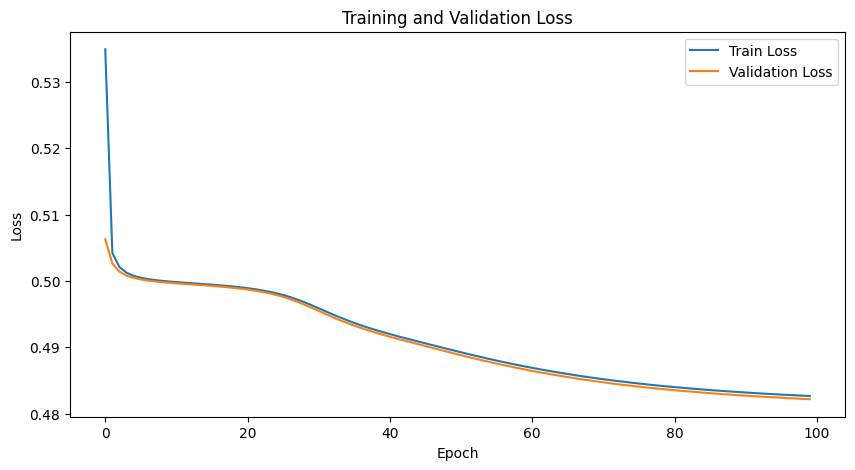

In [16]:
# Plot the training and validation curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [17]:
torch.save(best_encoder_model, encoder_path)

In [18]:
torch.save(best_decoder_model, decoder_path)

In [19]:
test_losses = []
running_test_loss = 0.0


progress_bar_test = tqdm(enumerate(test_loader), total=len(test_loader), ncols=100)
for index, (main_channels_mat) in progress_bar_test:
        
    main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1)
    
    with torch.no_grad():
            
        nn_output_enc = best_encoder_model(main_channels_mat_for_nn)
        nn_output = best_decoder_model(nn_output_enc)

        # Calculate losses
        test_loss = loss(nn_output, main_channels_mat_for_nn)

        # Update running loss
        running_test_loss += test_loss.item()
            
        avg_test_loss = running_test_loss / (index + 1)

        progress_bar_test.set_description(f'Test Loss:{avg_test_loss:.4f}')

test_losses.append(avg_test_loss)


est Loss:0.4822: 100%|██████████████████████████████████████████| 313/313 [00:02<00:00, 122.16it/s]